In [82]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

In [83]:
df = pd.read_csv("data\Mall_Customers.csv")

### Let's start with some exploratory data analysis to get to know our data

In [84]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [86]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [87]:
df["Gender"].value_counts(normalize=True) # gender distribution 

Gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64

Visualizing our data and their distribution helps understanding what we are working with, and find possible interesting relationships. I am using a series of different graphs for my exploration:

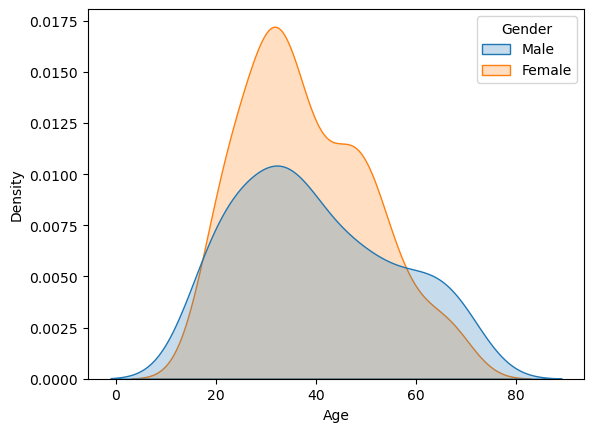

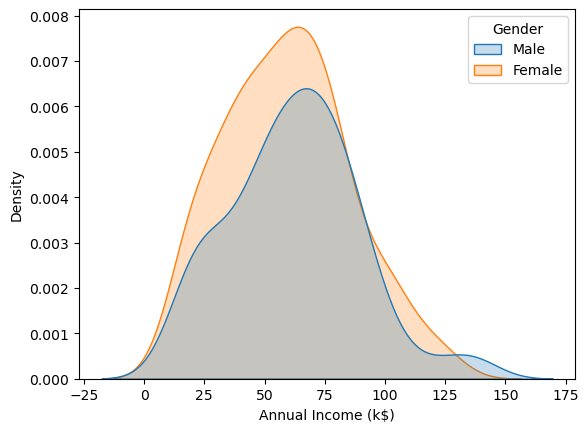

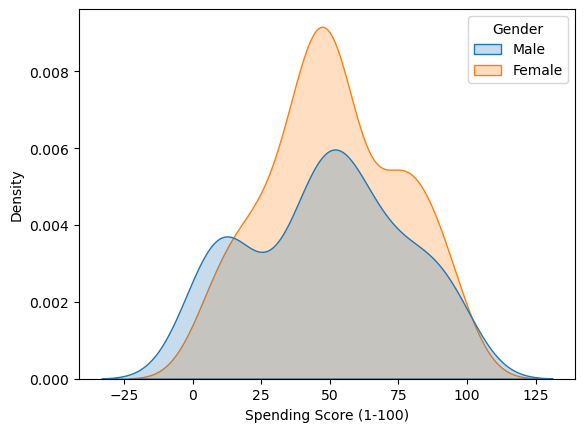

In [88]:
columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for i in columns:
    plt.figure()
    sns.kdeplot(x=i, data=df, hue="Gender", fill=True)

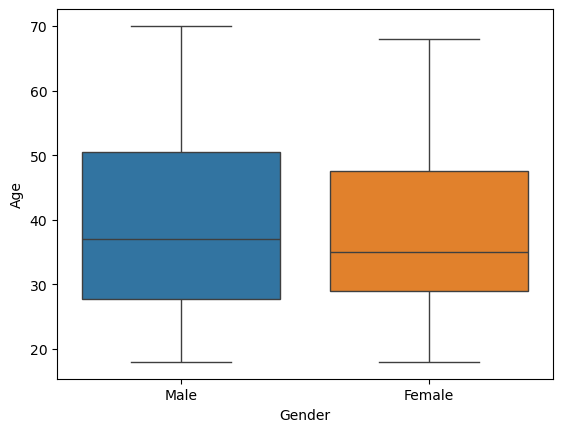

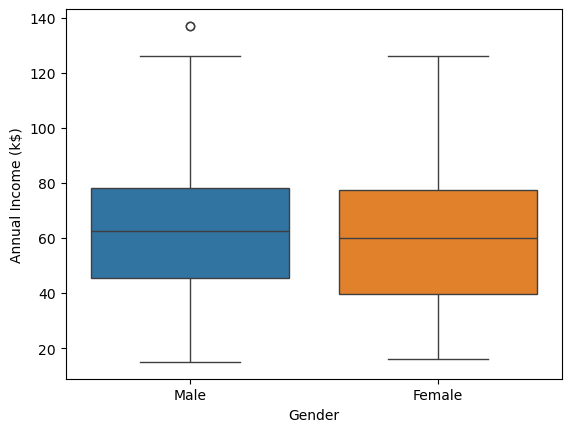

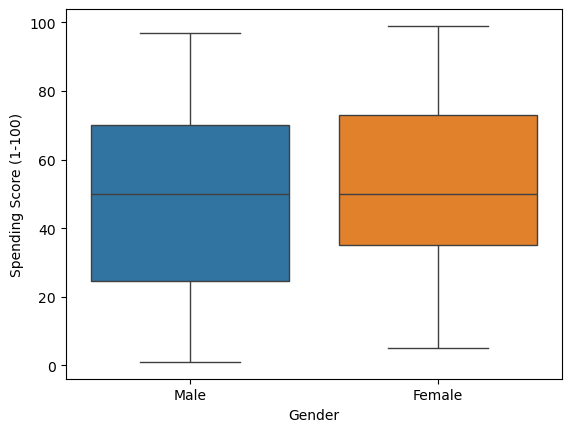

In [89]:
columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for i in columns:
    plt.figure()
    sns.boxplot(x="Gender", y=i, data=df, hue="Gender", fill=True)

There is an interesting relationship between annual income and spending score:

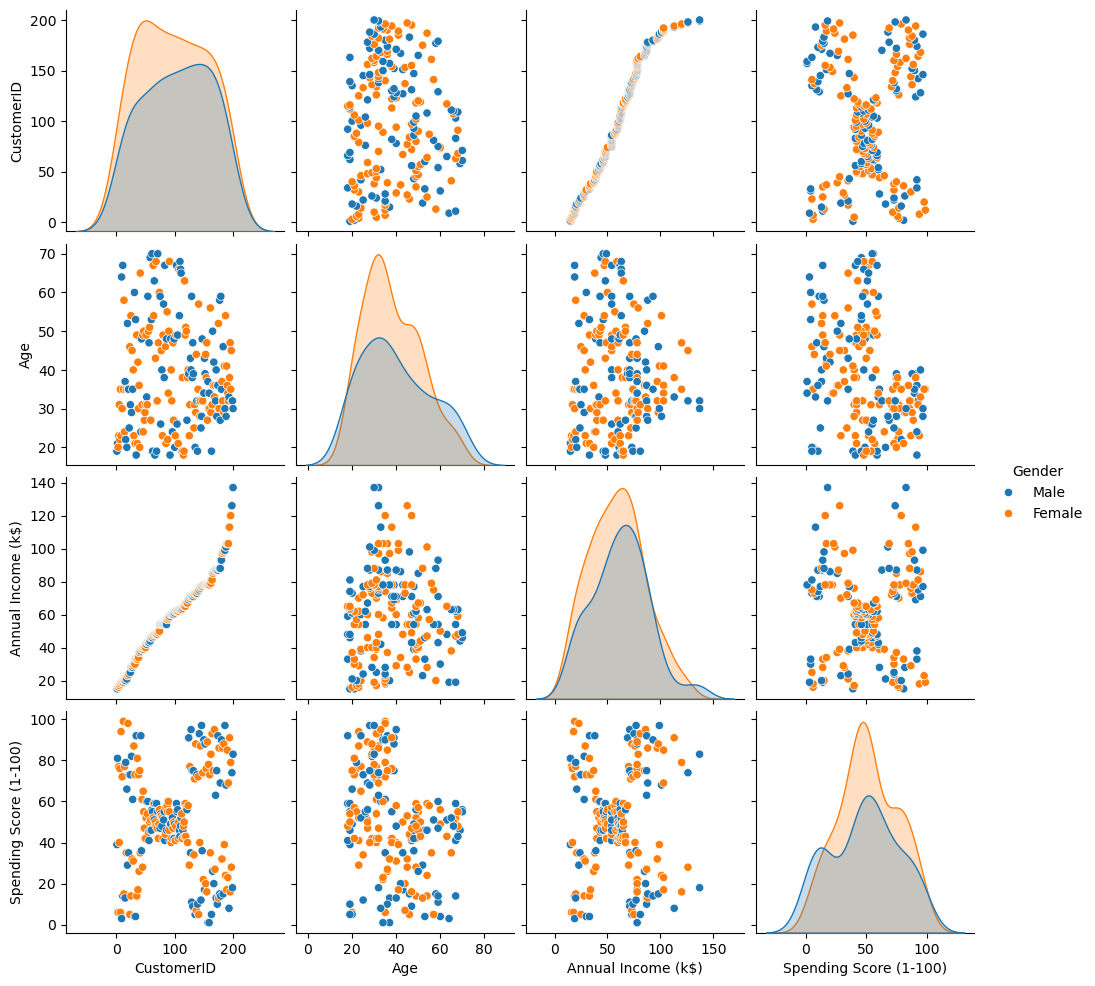

In [90]:
sns.pairplot(df, hue="Gender")
plt.show()

By giving a closer look at this relationship, we can already identify 5 possible clusters:

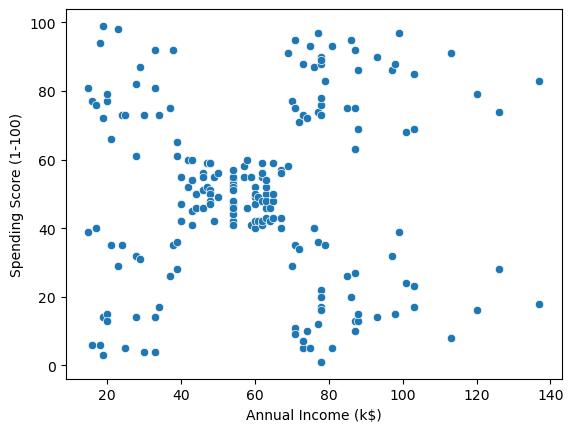

In [91]:
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", data=df)
plt.show()

When examining correlation, we observe a slight negative correlation between age and income, as well as between age and spending. As age increases, income and spending slightly decrease. 
Conversely, we see a slight positive correlation between income and spending score, with the latter increasing slightly as income rises.

In [92]:
df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


<Axes: >

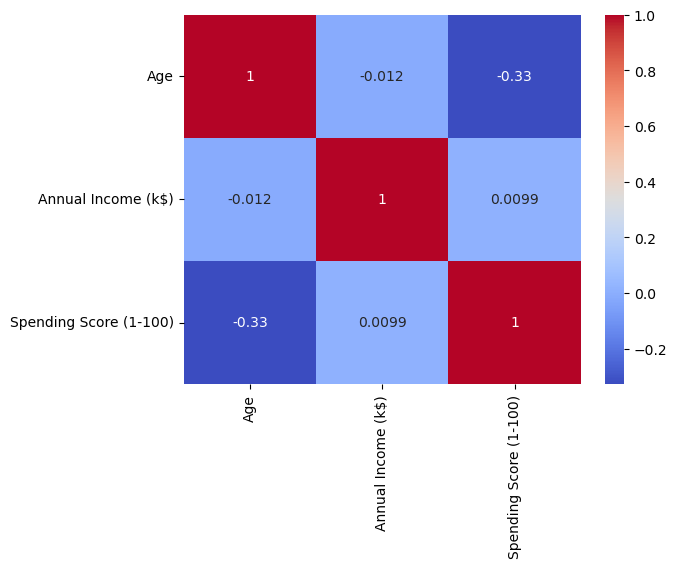

In [93]:
sns.heatmap(df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].corr(), annot=True, cmap="coolwarm")

### Bivariate clustering
The data suggests we should consider both income and spending score when clustering. We will fit 2 variables: **Annual Income (k$)** and **Spending Score (1-100)**.

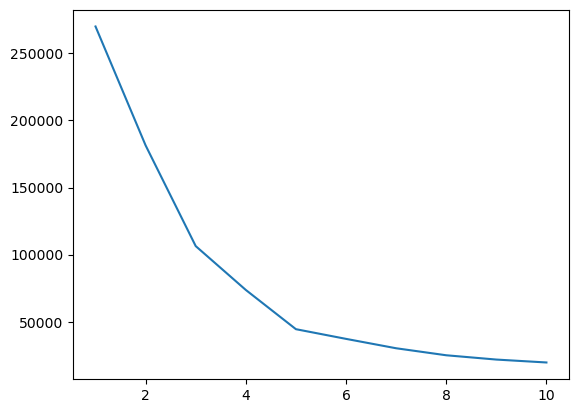

In [94]:
inertia_scores = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(df[['Annual Income (k$)', 'Spending Score (1-100)']])
    inertia_scores.append(kmeans.inertia_)
    
plt.plot(range(1,11), inertia_scores) # elbow method

In [95]:
clustering = KMeans(n_clusters=5, n_init=10)
clustering.fit(df[['Annual Income (k$)', 'Spending Score (1-100)']])
df["Spending and income cluster"] = clustering.labels_
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Spending and income cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,3
2,3,Female,20,16,6,4
3,4,Female,23,16,77,3
4,5,Female,31,17,40,4


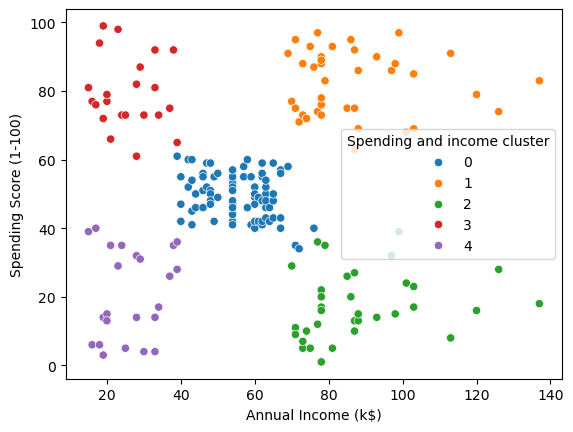

In [96]:
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", data=df, 
                hue="Spending and income cluster", palette="tab10")
plt.show()

I also want to add our cluster centers to the graph:

In [97]:
centers = pd.DataFrame(clustering.cluster_centers_)
centers.columns = ["x", "y"]
centers

,x,y
0,55.296296,49.518519
1,86.538462,82.128205
2,88.200000,17.114286
3,25.727273,79.363636
4,26.304348,20.913043


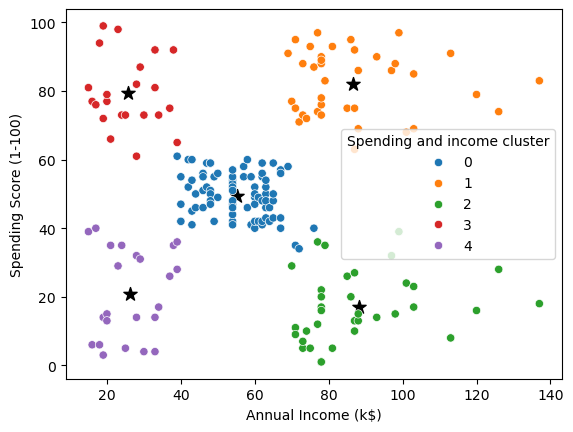

In [98]:
plt.scatter(x=centers["x"], y=centers["y"], s=100, c="black", marker="*") 
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", data=df, 
                hue="Spending and income cluster", palette="tab10")
plt.show()

I will quickly check our gender distribution for each cluster:

In [99]:
pd.crosstab(df["Spending and income cluster"], df["Gender"], normalize="index")

Gender,Female,Male
Spending and income cluster,,
0,0.592593,0.407407
1,0.538462,0.461538
2,0.457143,0.542857
3,0.590909,0.409091
4,0.608696,0.391304


And average age per cluster:

In [100]:
df.groupby("Spending and income cluster")[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].mean()

,Age,Annual Income (k$),Spending Score (1-100)
Spending and income cluster,,,
0,42.716049,55.296296,49.518519
1,32.692308,86.538462,82.128205
2,41.114286,88.200000,17.114286
3,25.272727,25.727273,79.363636
4,45.217391,26.304348,20.913043


**Cluster 1** has a low age and high annual income as well as high spending score. This has 53% females and 46% males. This is our ideal choice when it comes to running targeted marketing campaigns. We have all we need, so we can save our df:

In [101]:
df.to_csv("mall_customers_clustering")